# Dyscalculia Gradient Module

1. Does the NPC have a different connectivity profile? /dispersion in connectivity space?
2. Differences in integration between networks that constitute NPC ? Between Network Dispersion
3. Connectivity differences due to specific task phase? PPI

In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
from brainspace.gradient import GradientMaps
from numrisk.fmri_analysis.gradients.utils import get_basic_mask
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = op.join(bids_folder, 'plots_and_ims/gradient_stuff')

from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]

fsaverage = fetch_surf_fsaverage('fsaverage5') 

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()


## 1. NPC connectivity: only with itself  & to the whole brain

--> NPC-mask_gradient.ipynb / Dispersion&Eccentricity

test all combinations of 
1. cor_type = ['cm-subset', 'gm-subset']
2. n_grad = ['both 2D', 1, 2]

In [78]:
# within itself
cor_type =  'cm-subset'## 'covariance' # 
sparsity = '09'
spec = f'onlyNPC-{cor_type}' if  cor_type == 'covariance' else f'onlyNPC-{cor_type}_sparsity-{sparsity}'


In [54]:
# to the whole brain
cor_type = 'gm-subset'
spec = 'space-fsaverag5_n10'

from numrisk.fmri_analysis.gradients.utils_03 import get_nPRF_mask
nprf_r2_mask = get_nPRF_mask(bids_folder)

In [79]:
n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}

for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy'))
    if cor_type ==  'cm-subset' or cor_type == 'covariance':
        gm_aligned = gm_aligned.T
    elif cor_type == 'gm-subset':
        gm_aligned = gm_aligned[:, nprf_r2_mask]

    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

print(np.shape(gm_aligned))
print(np.shape(gms_aligned['g1']))


(6, 1510)
(66, 1510)


In [80]:
# 2D dispersion measure
n_grad = 'both 2D'
G_net = np.stack([np.array(gms_aligned['g1']).T, np.array(gms_aligned['g2']).T], axis=-1)  # shape: number of nodes in network x N x 2

centroid_cog_net = np.nanmedian(G_net, axis=0)  # shape: N x 2

# Compute the 2D Euclidean distance between each node and the centroid for each subject
dist_nodes_to_centroid = G_net - centroid_cog_net  # shape: number of nodes in network x N x 2
squared_distances = np.sum(dist_nodes_to_centroid**2, axis=-1)  # sum squares across 2D (last axis), shape: number of nodes in network x N

# Compute the within-network dispersion as the mean squared distance
NPC_2d_dispersion =  np.nanmean(squared_distances, axis=0)  # shape: N

df = pd.DataFrame(NPC_2d_dispersion.T, index=sub_array, columns=['NPC_2D_dispersion'])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))

In [71]:
# 1D
n_grad = 2
G1_net = np.array(gms_aligned[f'g{n_grad}']).T  # n_vertices x n_subjects

centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N

NPC_dispersion = np.nanmean((dist_nodes_to_centroid**2), axis = 0) 

df = pd.DataFrame(np.array([NPC_dispersion, centroid_cog_net]).T, index=sub_array, columns=['NPC_dispersion', 'NPC_centroid'])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))


TtestResult(statistic=0.0698081844643804, pvalue=0.9446197767388703, df=50.91833817394906)


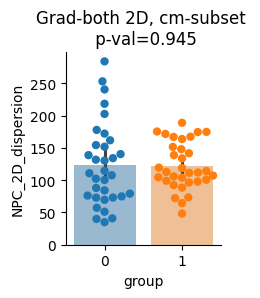

In [81]:
from scipy.stats import ttest_ind

y_var = 'NPC_2D_dispersion' if n_grad == 'both 2D' else 'NPC_dispersion' # #  'NPC_centroid' # 

tmp = df.copy()

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=y_var, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=y_var, size=6,legend=False)
stats = ttest_ind(tmp.xs(0,0,'group')[y_var], tmp.xs(1,0,'group')[y_var], axis=0, equal_var=False)
p_val = np.round(stats.pvalue,3)
print(stats)

n_grad = 'both 2D' if y_var == 'NPC_2D_dispersion' else n_grad
axes.set(title=f'Grad-{n_grad}, {cor_type} \n p-val={p_val}',ylabel=y_var, xlabel='group')
sns.despine()

## 2. Between network dispersion of nets constituting NPC

In [83]:
from numrisk.fmri_analysis.gradients.utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

from brainspace.utils.parcellation import map_to_labels
caNets_fsav5_mapping = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]


In [86]:
# load in gradients
spec = 'space-fsaverag5_n10'

n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}

for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy'))
    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

In [95]:
n_grad = 1 #'both 2D'

centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)
for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    # Identify the nodes of the given Yeo network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0]  # get (Glasser space) indices
    netNodes = np.squeeze(netNodes)

    if n_grad == 'both 2D':
        G1_net = np.array(gms_aligned['g1']).T[netNodes]  # shape: number of nodes in network x N
        G2_net = np.array(gms_aligned['g2']).T[netNodes]  # shape: number of nodes in network x N
        G_net = np.stack([G1_net, G2_net], axis=-1)  # shape: number of nodes in network x N x 2
    else:
        G_net = np.array(gms_aligned[f'g{n_grad}']).T[netNodes]

    centroid_cog_net = np.nanmedian(G_net, axis=0)  # shape: N x 2
    centroids_net.append(centroid_cog_net)

centroids_net = np.array(centroids_net)  # shape: N_nets x N_subs x 2 


In [96]:
from scipy.stats import ttest_ind
test_name = '2sample_TTest'

N_nets = 12
mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets]) # = Tvals !

distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(n1, N_nets):
        #print(n1, n2)
        if n_grad == 'both 2D':
            distance = np.linalg.norm(centroids_net[n1] - centroids_net[n2], axis=1)
        else:
            distance = np.abs(centroids_net[n1] - centroids_net[n2]) # (12, 66)
        distances.append(distance)

        df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
        df.index.name = 'subject'
        df = df.join(group_list['group']).set_index('group',append=True)
        group_0 = df.xs(0, 0, 'group').values.flatten()  # Ensure 1D
        group_1 = df.xs(1, 0, 'group').values.flatten()  # Ensure 1D
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)

        mat_rs[n1, n2] = np.round(t_stat, 3)
        mat_pvals[n1, n2] = np.round(p_val, 4)

        net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))


Text(0.5, 1.1, '2sample_TTest between network distance \n grad-1')

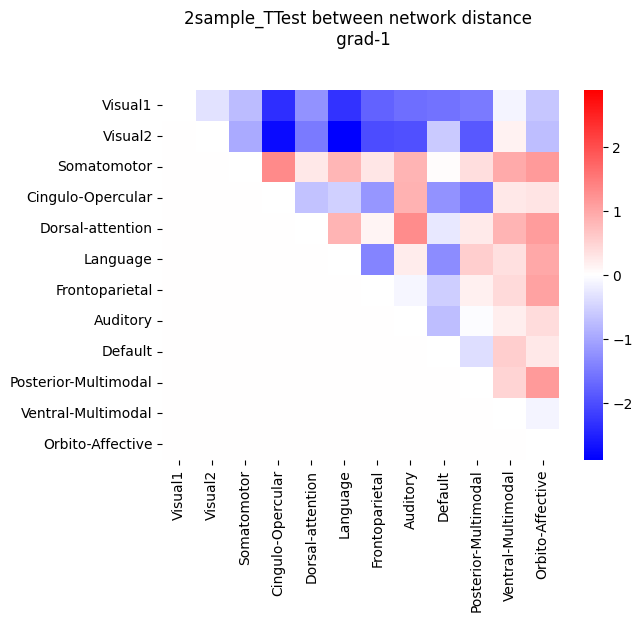

In [98]:
grad_name = '2D gradient space' if n_grad == 'both 2D' else f'grad-{n_grad}'

t_max = np.nanmax(np.abs(mat_rs.flatten())) 
sns.heatmap(mat_rs, cmap='bwr',vmin=-t_max,vmax=t_max,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'{test_name} between network distance \n {grad_name}', y=1.1)

In [99]:
# only multiple comparison over networks contained within NPC mask
network_labels = range(1, 13)
NPC_nets = [ 1,  2,  3,  4,  5,  7,  9, 10]
region_mask = np.isin(network_labels, NPC_nets)  # network_labels should match mat_pvals structure

mask = (mat_pvals != 1) & ~np.isnan(mat_pvals) & region_mask
pvals = mat_pvals[mask]
pvals = pvals[~np.isnan(pvals)]

from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Create a new matrix for corrected p-values
corrected_mat_pvals = np.full(mat_pvals.shape, np.nan)
mask = (mat_pvals != 1) & ~np.isnan(mat_pvals) & region_mask
corrected_mat_pvals[mask] = pvals_corrected

Text(0.5, 1.01, 'Corrected  P-vals \n 2sample_TTest - between network distance \n grad-1')

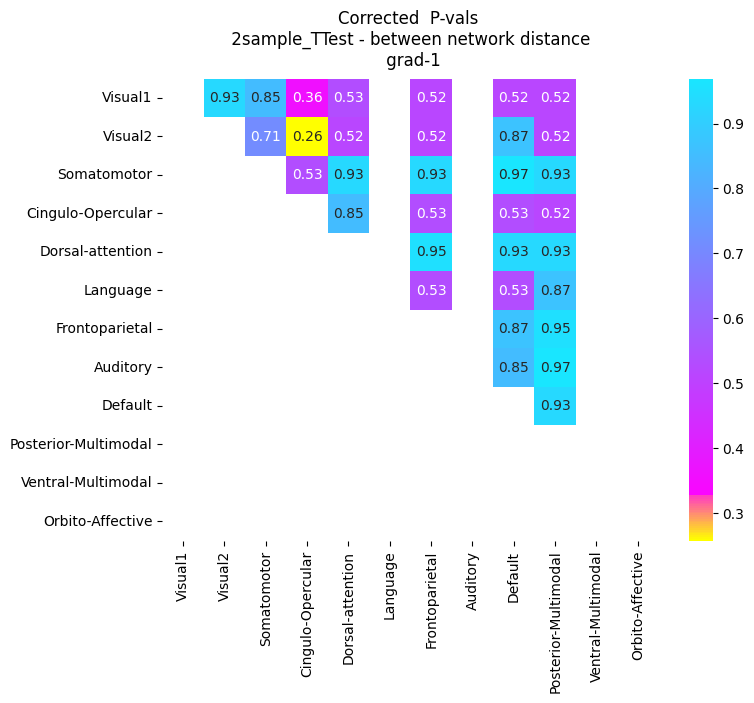

In [101]:
from numrisk.fmri_analysis.gradients.utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(corrected_mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Corrected  P-vals \n {test_name} - between network distance \n {grad_name}', y=1.01)

TtestResult(statistic=-1.4920624827703082, pvalue=0.14063143551409, df=63.539580736520925)


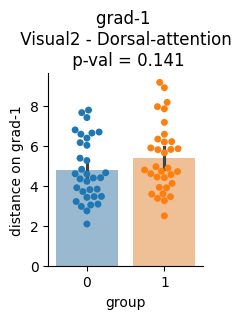

In [107]:
df_dist = pd.DataFrame(np.array(distances).T, index=sub_array, columns=net_name_comps)
df_dist.index.name = 'subject'
df_dist = df_dist.join(group_list).set_index('group',append=True)

net_comb = 'Visual2 - Dorsal-attention'
fig, axes = plt.subplots(1,1, figsize=(2,2.5)) # , sharex=True, sharey=True

sns.barplot(data=df_dist.reset_index(), x ='group', hue='group',y=net_comb, alpha=0.5,legend=False, ax=axes)
sns.swarmplot(data=df_dist.reset_index(),  x ='group', hue='group',y=net_comb, size=5,legend=False, ax=axes)

stats = ttest_ind(df_dist.xs(0,0,'group')[net_comb], df_dist.xs(1,0,'group')[net_comb], equal_var=False)  # Welch's t-test
p_val = np.round(stats.pvalue,3)
print(stats)

axes.set(title=f'{grad_name} \n {net_comb} \n p-val = {p_val}', ylabel='')
sns.despine()
axes.set(ylabel=f'distance on grad-{n_grad}')
fig.subplots_adjust(wspace=1)

## ADDDitional

In [ ]:
sub_array = np.array([int(i) for i in subList])
dfs = []
for i in range(n_gradients):
    gradient_df = pd.DataFrame(gms_aligned[f'g{i+1}'], index=sub_array)
    gradient_df.index.name = 'subject'
    gradient_df = gradient_df.join(group_list).set_index('group', append=True)
    gradient_df['n_gradient'] = i + 1
    dfs.append(gradient_df.set_index('n_gradient', append=True))

df_gms = pd.concat(dfs).sort_index(level='n_gradient')

In [ ]:
# from other script... which gets group differences
n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}

for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm, f'sub-{sub}_g-aligned_{spec}.npy'))

    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

n_grad = 2
g1 = np.array(gms_aligned[f'g{n_grad}']).T # n_vertices x n_subjects

# get the gradient loadings of the nodes of the ROI, for each subject (shape: number of nodes in network x N)
G1_net = g1[nprf_r2_mask]

centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N

NPC_dispersion = np.nanmean((dist_nodes_to_centroid**2), axis = 0) 

df = pd.DataFrame(np.array([NPC_dispersion, centroid_cog_net]).T, index=sub_array, columns=['NPC_dispersion', 'NPC_centroid'])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))
print(np.shape(G1_net))
G1_net